# MRI Datasets Analysis

This notebook analyzes multiple MRI dataset metadata files to extract key information including:

- Number of participants per dataset
- Age and sex distributions
- Dementia prevalence, where available
- MRI modalities available in each dataset

It then adds two extra functionalities:

1. **Additional Modality Analysis:** A section where you can specify a modality (or let the code aggregate all) so it shows the total number of MRI images (by summing the participant counts from datasets containing that modality) along with a modality distribution graph.

2. **3D Equal Distribution Analysis:** A synthetic 3D visualization showing an equal distribution across age (binned), sex, and modality.

Enjoy the analysis!

In [125]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

In [126]:
## Data Loading
def read_file(filename):
    """Read file based on extension and return dataframe"""
    ext = filename.split('.')[-1].lower()
    
    if ext == 'tsv':
        return pd.read_csv(filename, sep='\t')
    elif ext == 'csv':
        return pd.read_csv(filename)
    elif ext in ['xls', 'xlsx']:
        return pd.read_excel(filename)
    else:
        print(f"Unsupported file format: {ext}")
        return None

# Read all dataset files
file_names = [
    # "IXI.xls",
    # "openbhb_train_participants.tsv",
    # "openbhb_val_participants.tsv",
    "oasis2_longitudinal_demographics.xlsx",
    "OASIS3_demographics.csv",
    "bold_var_participants.tsv",
    "camcan_participants.tsv",
    "oasis1_cross-sectional-5708aa0a98d82080.xlsx",
    "dallas_participants.tsv",
    "narr_participants.tsv",
    "npc_participants.tsv",
    "mpi_leizig_participants.tsv",
    "SALD_sub_information.xlsx"
]

# Dictionary to store dataframes (update base_path as needed)
dfs = {}
base_path = 'C:/Projects/thesis_project/Data/all_demographics/'
for file in file_names:
    df_name = file.split('.')[0]
    dfs[df_name] = read_file(base_path + file)
    if dfs[df_name] is not None:
        print(f"Loaded {file}: {dfs[df_name].shape[0]} rows, {dfs[df_name].shape[1]} columns")

for key in dfs.keys():
    if dfs[key] is not None:
        print(f"Columns in {key}: {dfs[key].columns.tolist()}")

Loaded oasis2_longitudinal_demographics.xlsx: 373 rows, 15 columns
Loaded OASIS3_demographics.csv: 1378 rows, 19 columns
Loaded bold_var_participants.tsv: 158 rows, 11 columns
Loaded camcan_participants.tsv: 653 rows, 6 columns
Loaded oasis1_cross-sectional-5708aa0a98d82080.xlsx: 436 rows, 12 columns
Loaded dallas_participants.tsv: 464 rows, 36 columns
Loaded narr_participants.tsv: 345 rows, 6 columns
Loaded npc_participants.tsv: 66 rows, 37 columns
Loaded mpi_leizig_participants.tsv: 318 rows, 3 columns
Loaded SALD_sub_information.xlsx: 494 rows, 7 columns
Columns in oasis2_longitudinal_demographics: ['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
Columns in OASIS3_demographics: ['OASISID', 'Subject_accession', 'AgeatEntry', 'AgeatDeath', 'GENDER', 'EDUC', 'SES', 'racecode', 'race', 'ETHNIC', 'AIAN', 'NHPI', 'ASIAN', 'AA', 'WHITE', 'daddem', 'momdem', 'HAND', 'APOE']
Columns in bold_var_participants: ['p

In [127]:
## Helper Functions
def get_unique_participants(df):
    """Extract unique participant count from dataframe"""
    id_patterns = ['oasisid', 'participant_id', 'subject', 'id', 'oasis']
    
    for pattern in id_patterns:
        matching_cols = [col for col in df.columns if pattern.lower() in col.lower()]
        if matching_cols:
            return df[matching_cols[0]].nunique()
    
    return df.shape[0]

def get_age_info(df):
    """Extract age statistics from dataframe"""
    age_patterns = ['age', 'agec', 'agem']
    age_cols = []
    
    for pattern in age_patterns:
        matching_cols = [col for col in df.columns if pattern.lower() in col.lower()]
        age_cols.extend(matching_cols)
    
    if not age_cols:
        return {'mean': np.nan, 'min': np.nan, 'max': np.nan}
    
    for col in age_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            valid_ages = df[col].dropna()
            if not valid_ages.empty:
                return {
                    'mean': valid_ages.mean(),
                    'min': valid_ages.min(),
                    'max': valid_ages.max()
                }
        else:
            try:
                numeric_ages = pd.to_numeric(df[col], errors='coerce')
                valid_ages = numeric_ages.dropna()
                if not valid_ages.empty:
                    return {
                        'mean': valid_ages.mean(),
                        'min': valid_ages.min(),
                        'max': valid_ages.max()
                    }
            except:
                continue
    
    return {'mean': np.nan, 'min': np.nan, 'max': np.nan}

def get_sex_distribution(df):
    """Extract sex distribution from dataframe"""
    sex_patterns = ['sex', 'gender', 'm/f']
    sex_cols = []
    
    for pattern in sex_patterns:
        matching_cols = [col for col in df.columns if pattern.lower() in col.lower()]
        sex_cols.extend(matching_cols)
    
    if not sex_cols:
        return {'male': np.nan, 'female': np.nan, 'unknown': np.nan}
    
    sex_col = sex_cols[0]
    sex_values = df[sex_col].fillna('Unknown').astype(str).str.lower()
    
    male_count = sum(sex_values.isin(['m', 'male', '1', 'boy', 'man']) |
                     sex_values.str.contains('^m$', regex=True))
    
    female_count = sum(sex_values.isin(['f', 'female', '2', 'girl', 'woman']) |
                       sex_values.str.contains('^f$', regex=True))
    
    unknown_count = len(sex_values) - male_count - female_count
    
    total = len(sex_values)
    return {
        'male': (male_count / total) * 100 if total > 0 else np.nan,
        'female': (female_count / total) * 100 if total > 0 else np.nan,
        'unknown': (unknown_count / total) * 100 if total > 0 else np.nan
    }

def get_dementia_info(df):
    """Extract dementia prevalence from dataframe"""
    dementia_patterns = ['dement', 'cdr', 'diagnosis', 'group', 'mmse']
    dementia_cols = []
    
    for pattern in dementia_patterns:
        matching_cols = [col for col in df.columns if pattern.lower() in col.lower()]
        dementia_cols.extend(matching_cols)
    
    if not dementia_cols:
        return np.nan
    
    for col in dementia_cols:
        col_lower = col.lower()
        
        # CDR (Clinical Dementia Rating) approach
        if 'cdr' in col_lower:
            if pd.api.types.is_numeric_dtype(df[col]):
                dementia_count = sum(df[col] > 0)
                total = sum(~df[col].isna())
            else:
                try:
                    numeric_vals = pd.to_numeric(df[col], errors='coerce')
                    dementia_count = sum(numeric_vals > 0)
                    total = sum(~numeric_vals.isna())
                except:
                    continue
        
        # Diagnosis or Group approach
        elif 'diagnosis' in col_lower or 'group' in col_lower:
            values = df[col].fillna('Unknown').astype(str).str.lower()
            dementia_count = sum(values.str.contains('dement|alzheimer|ad|mci', regex=True, na=False))
            total = sum(values != 'unknown')
        
        # MMSE approach
        elif 'mmse' in col_lower:
            if pd.api.types.is_numeric_dtype(df[col]):
                mmse_vals = df[col].dropna()
                dementia_count = sum(mmse_vals < 24)
                total = len(mmse_vals)
            else:
                try:
                    mmse_numeric = pd.to_numeric(df[col], errors='coerce')
                    mmse_vals = mmse_numeric.dropna()
                    dementia_count = sum(mmse_vals < 24)
                    total = len(mmse_vals)
                except:
                    continue
        else:
            continue
            
        if 'dementia_count' in locals() and 'total' in locals() and total > 0:
            return (dementia_count / total) * 100
            
    return np.nan

def get_mri_modalities(df):
    """Detect MRI modalities available in the dataset"""
    modality_map = {
        'T1': ['t1', 't1w', 't1-'],
        'T2': ['t2', 't2w', 't2-'],
        'FLAIR': ['flair'],
        'DWI': ['dwi', 'dti', 'diffusion'],
        'fMRI': ['fmri', 'func', 'bold', 'rest'],
        'PET': ['pet', 'amyloid', 'tau']
    }
    
    found_modalities = []
    
    # Check column names for modality indicators
    for modality, keywords in modality_map.items():
        for keyword in keywords:
            if any(keyword in col.lower() for col in df.columns):
                found_modalities.append(modality)
                break
    
    return ', '.join(found_modalities) if found_modalities else 'Unknown'

In [128]:
## Dataset Summary Creation
def create_dataset_summary(dfs):
    """Create summary statistics for all datasets"""
    summary_data = []
    
    for name, df in dfs.items():
        if df is None:
            continue
        participants = get_unique_participants(df)
        age_info = get_age_info(df)
        sex_dist = get_sex_distribution(df)
        dementia_percent = get_dementia_info(df)
        modalities = get_mri_modalities(df)
        
        summary_data.append({
            'Dataset': name,
            'Participants': participants,
            'Mean Age': age_info['mean'],
            'Min Age': age_info['min'],
            'Max Age': age_info['max'],
            'Male %': sex_dist['male'],
            'Female %': sex_dist['female'],
            'Unknown Sex %': sex_dist['unknown'],
            'Dementia %': dementia_percent,
            'MRI Modalities': modalities
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Add total/average row
    total_row = {
        'Dataset': 'TOTAL',
        'Participants': summary_df['Participants'].sum(),
        'Mean Age': summary_df['Mean Age'].mean(),
        'Min Age': summary_df['Min Age'].min(),
        'Max Age': summary_df['Max Age'].max(),
        'Male %': summary_df['Male %'].mean(),
        'Female %': summary_df['Female %'].mean(),
        'Unknown Sex %': summary_df['Unknown Sex %'].mean(),
        'Dementia %': summary_df['Dementia %'].mean(),
        'MRI Modalities': 'Combined'
    }
    
    summary_df = pd.concat([summary_df, pd.DataFrame([total_row])], ignore_index=True)
    return summary_df

# Generate summary
dataset_summary = create_dataset_summary(dfs)
print("\nDataset Summary:")
print(dataset_summary)
dataset_summary


Dataset Summary:
                                    Dataset  Participants   Mean Age  Min Age  \
0          oasis2_longitudinal_demographics           150  77.013405  60.0000   
1                       OASIS3_demographics          1378  69.055993  42.4986   
2                     bold_var_participants           158  49.278481  20.0000   
3                       camcan_participants           653  54.310873  18.0000   
4   oasis1_cross-sectional-5708aa0a98d82080           436  51.357798  18.0000   
5                       dallas_participants           464  58.312500  21.0000   
6                         narr_participants           345  22.009804  18.0000   
7                          npc_participants            66  26.621212  20.0000   
8                   mpi_leizig_participants           318        NaN      NaN   
9                      SALD_sub_information           494  45.184211  19.0000   
10                                    TOTAL          4462  50.349364  18.0000   

    Max A

,Dataset,Participants,Mean Age,Min Age,Max Age,Male %,Female %,Unknown Sex %,Dementia %,MRI Modalities
0,oasis2_longitudinal_demographics,150,77.013405,60.0000,98.0000,42.895442,57.104558,0.000000,44.772118,Unknown
1,OASIS3_demographics,1378,69.055993,42.4986,95.6329,45.137881,54.862119,0.000000,NaN,Unknown
2,bold_var_participants,158,49.278481,20.0000,86.0000,37.341772,62.658228,0.000000,NaN,"T1, T2, DWI, fMRI"
3,camcan_participants,653,54.310873,18.0000,88.0000,49.464012,50.535988,0.000000,NaN,Unknown
4,oasis1_cross-sectional-5708aa0a98d82080,436,51.357798,18.0000,96.0000,38.532110,61.467890,0.000000,42.553191,Unknown
5,dallas_participants,464,58.312500,21.0000,89.0000,38.146552,61.853448,0.000000,0.000000,PET
6,narr_participants,345,22.009804,18.0000,45.0000,14.782609,16.231884,68.985507,NaN,Unknown
7,npc_participants,66,26.621212,20.0000,35.0000,43.939394,54.545455,1.515152,NaN,Unknown
8,mpi_leizig_participants,318,NaN,NaN,NaN,59.433962,40.566038,0.000000,NaN,Unknown
9,SALD_sub_information,494,45.184211,19.0000,80.0000,37.449393,62.145749,0.404858,NaN,T1


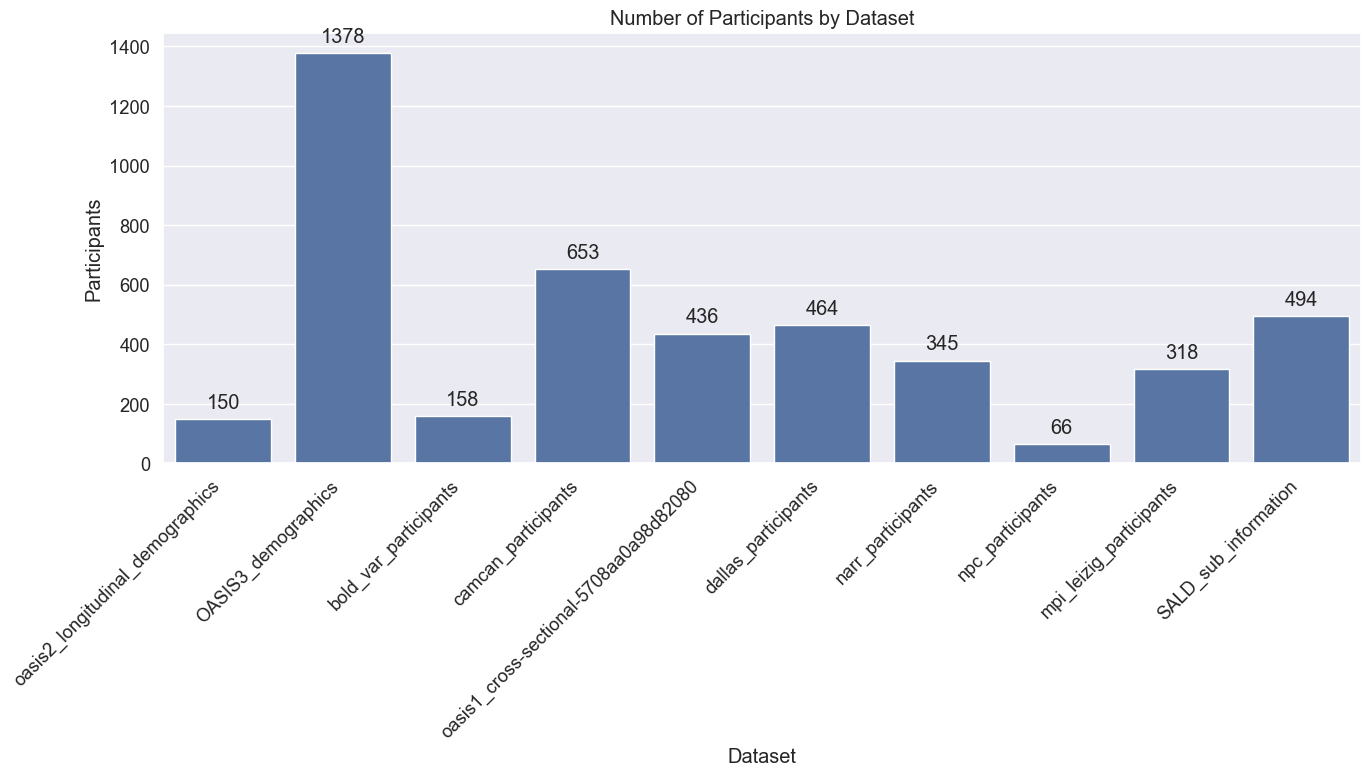

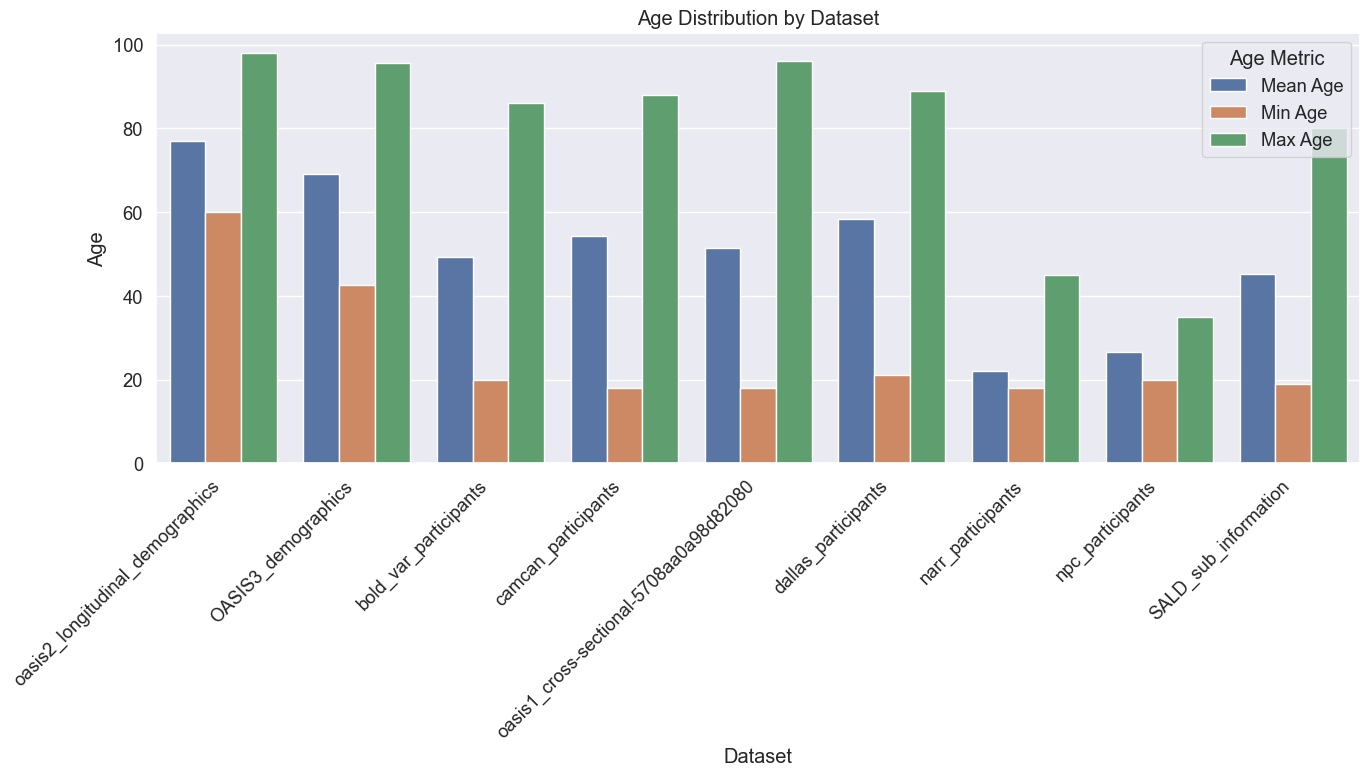

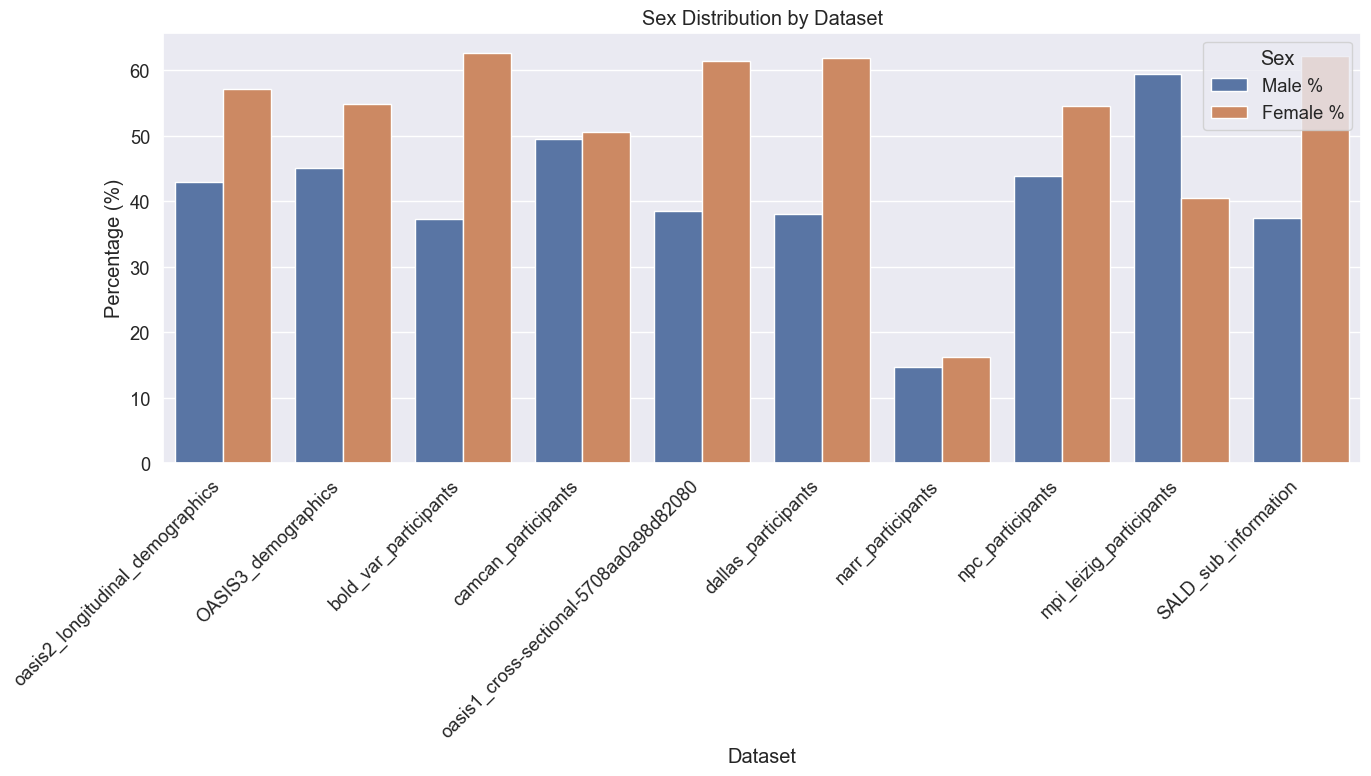

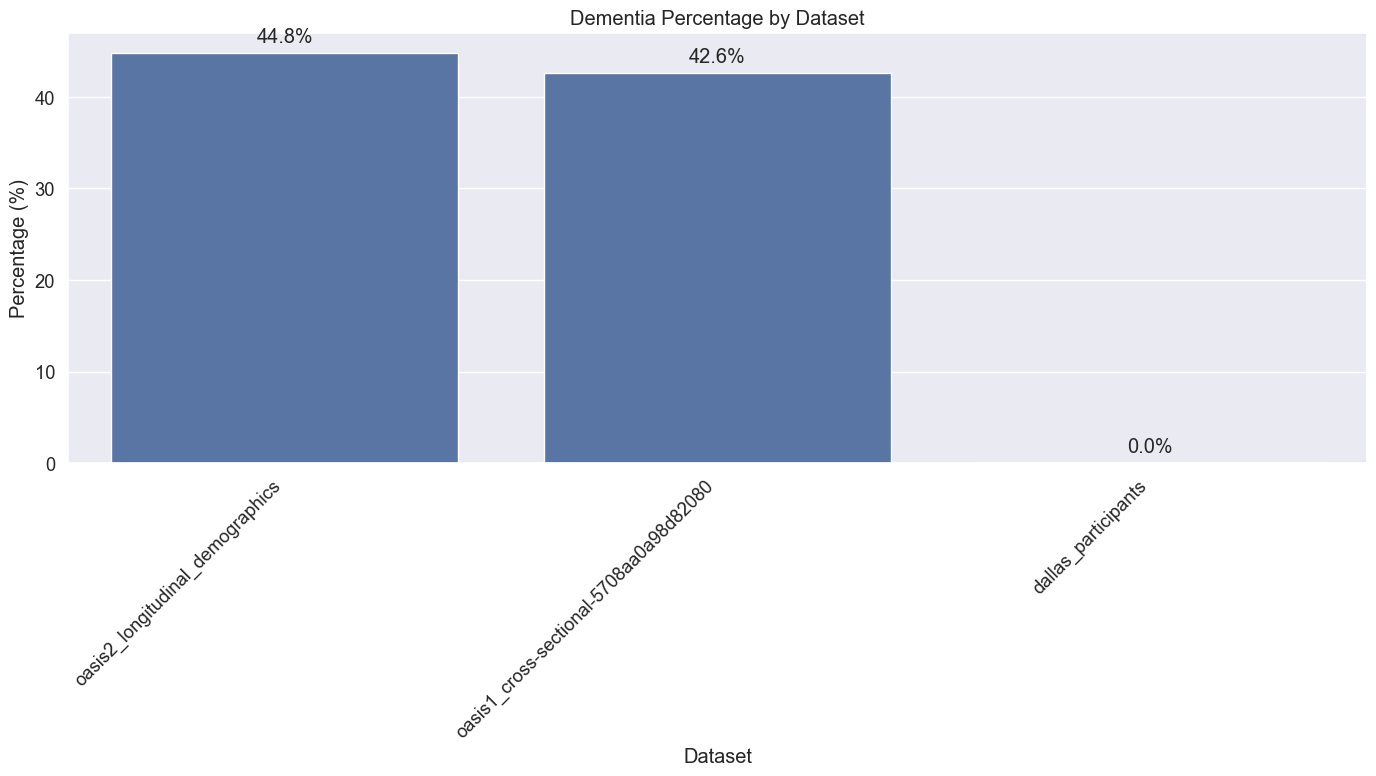

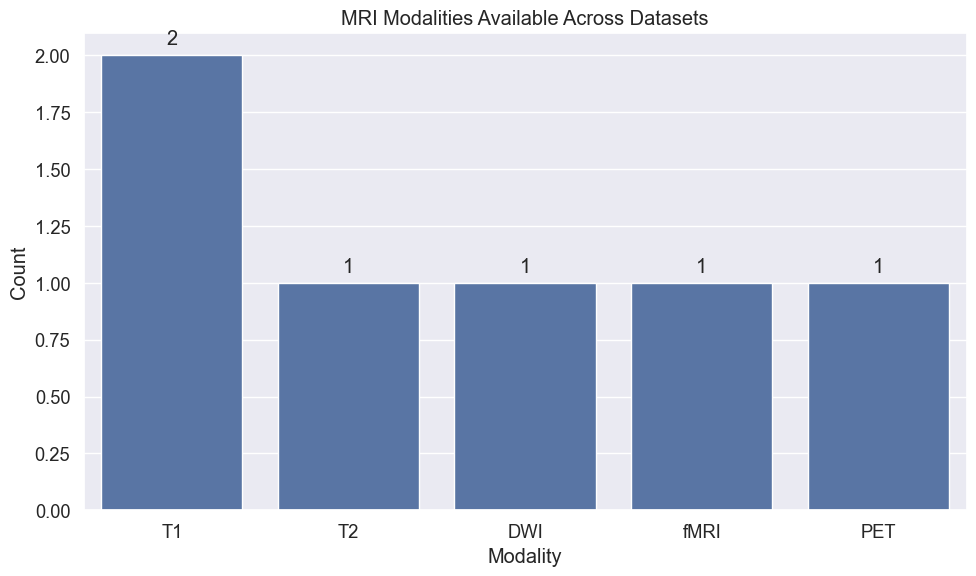

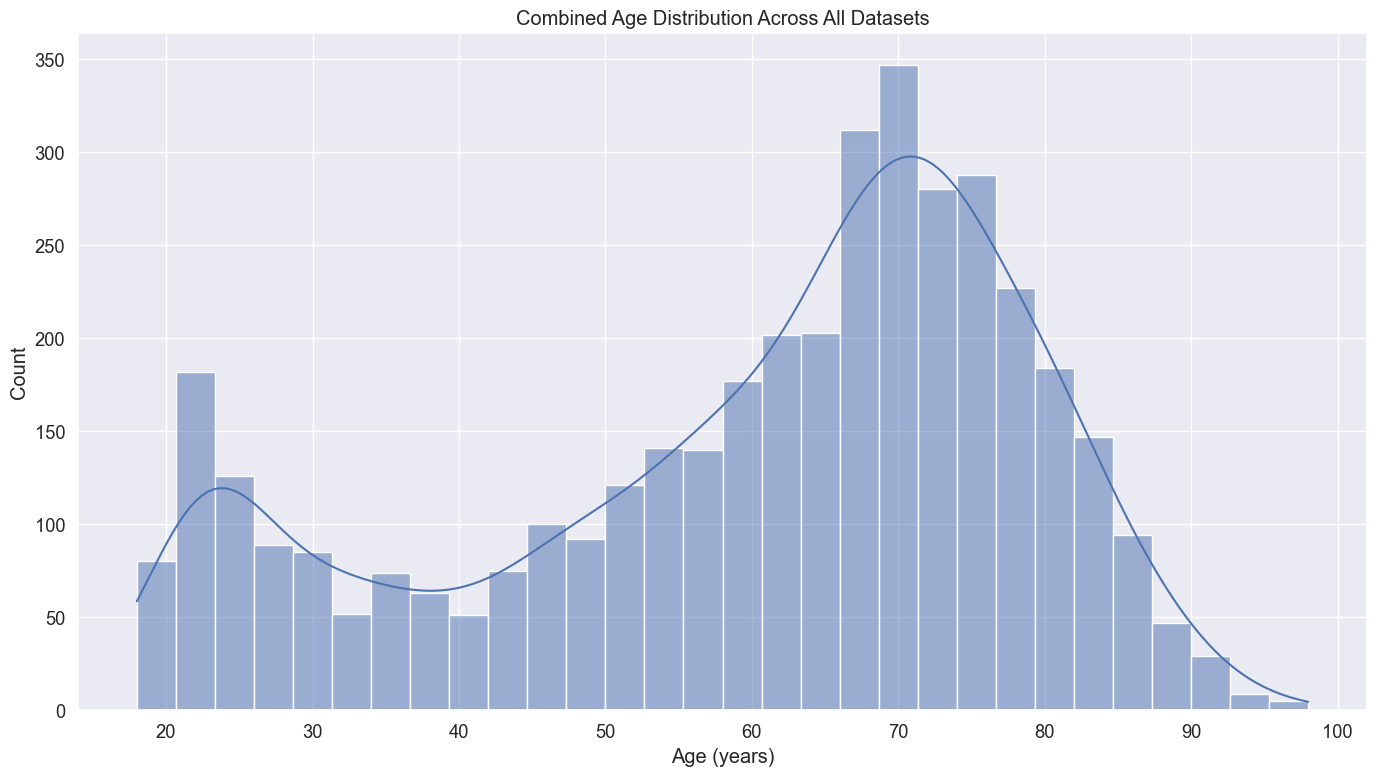

In [129]:
## Visualizations
# 1. Number of participants per dataset
plt.figure(figsize=(14, 8))
plot_data = dataset_summary[dataset_summary['Dataset'] != 'TOTAL']
ax = sns.barplot(x='Dataset', y='Participants', data=plot_data)
plt.title('Number of Participants by Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', 
                xytext = (0, 5), textcoords = 'offset points')

plt.savefig('participants_by_dataset.png')
plt.show()

# 2. Age distribution by dataset
plt.figure(figsize=(14, 8))
age_data = plot_data[['Dataset', 'Mean Age', 'Min Age', 'Max Age']].dropna()
age_data = age_data.melt(id_vars=['Dataset'], var_name='Age Metric', value_name='Age')
sns.barplot(x='Dataset', y='Age', hue='Age Metric', data=age_data)
plt.title('Age Distribution by Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('age_by_dataset.png')
plt.show()

# 3. Sex distribution by dataset
plt.figure(figsize=(14, 8))
sex_data = plot_data[['Dataset', 'Male %', 'Female %']].dropna()
sex_data = sex_data.melt(id_vars=['Dataset'], var_name='Sex', value_name='Percentage')
sns.barplot(x='Dataset', y='Percentage', hue='Sex', data=sex_data)
plt.title('Sex Distribution by Dataset')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage (%)')
plt.tight_layout()
plt.savefig('sex_by_dataset.png')
plt.show()

# 4. Dementia percentage by dataset (if available)
dementia_data = plot_data[['Dataset', 'Dementia %']].dropna()
if not dementia_data.empty:
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='Dataset', y='Dementia %', data=dementia_data)
    plt.title('Dementia Percentage by Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Percentage (%)')
    
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'bottom', 
                    xytext = (0, 5), textcoords = 'offset points')
    
    plt.tight_layout()
    plt.savefig('dementia_by_dataset.png')
    plt.show()

# 5. MRI modalities distribution based on summary (from get_mri_modalities)
modality_data = defaultdict(int)

for idx, row in dataset_summary.iterrows():
    if row['Dataset'] != 'TOTAL' and row['MRI Modalities'] != 'Unknown':
        for modality in row['MRI Modalities'].split(', '):
            modality_data[modality] += 1

if modality_data:
    plt.figure(figsize=(10, 6))
    modality_df = pd.DataFrame({
        'Modality': list(modality_data.keys()),
        'Count': list(modality_data.values())
    })
    ax = sns.barplot(x='Modality', y='Count', data=modality_df)
    
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'bottom', 
                    xytext = (0, 5), textcoords = 'offset points')
    
    plt.title('MRI Modalities Available Across Datasets')
    plt.tight_layout()
    plt.savefig('modality_distribution.png')
    plt.show()

# Combined Age Distribution across all datasets
all_ages = []
dataset_labels = []

for name, df in dfs.items():
    if df is None:
        continue
    age_cols = [col for col in df.columns if 'age' in col.lower()]
    if age_cols:
        for col in age_cols:
            if pd.api.types.is_numeric_dtype(df[col]):
                valid_ages = df[col].dropna()
                if not valid_ages.empty and valid_ages.max() < 120:
                    all_ages.extend(valid_ages)
                    dataset_labels.extend([name] * len(valid_ages))
                break

if all_ages:
    age_df = pd.DataFrame({'Age': all_ages, 'Dataset': dataset_labels})
    plt.figure(figsize=(14, 8))
    sns.histplot(data=age_df, x='Age', kde=True, bins=30)
    plt.title('Combined Age Distribution Across All Datasets')
    plt.xlabel('Age (years)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('combined_age_distribution.png')
    plt.show()

Total number of 'T1' images: 4312
Total number of 'T2' images: 2879
Total number of 'FLAIR' images: 2318
Total number of 'DWI' images: 0
Total number of 'FUNC' images: 0


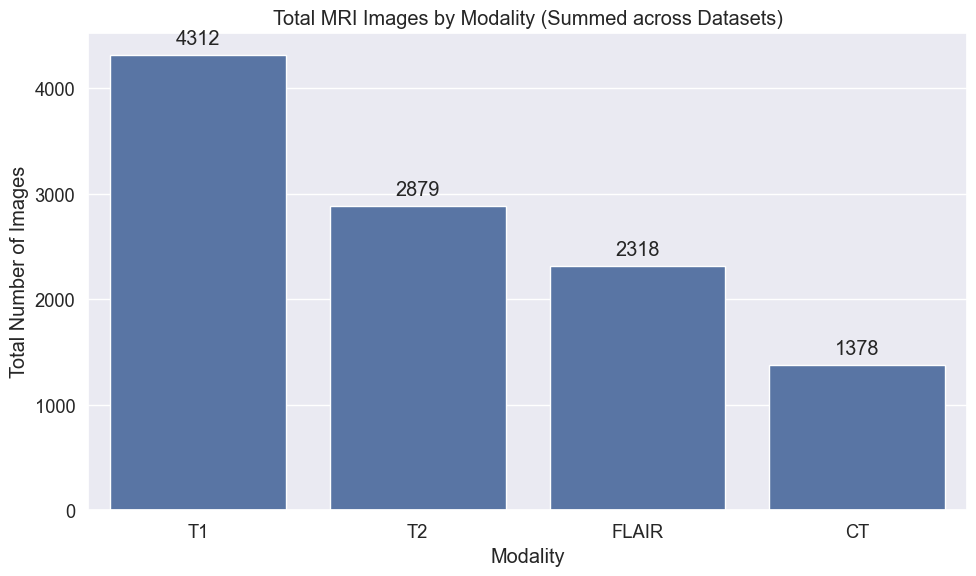

In [130]:
## Additional Modality Analysis
# Here we use the modalities defined in your table to compute the number of MRI images per modality.
# We assume that if a dataset has a given modality, then each participant contributes one image of that modality.

# Define the modality mapping based on your provided table.
# IMPORTANT: The keys here should match the keys used in the 'dfs' dictionary (i.e. the base filename without extension).
dataset_modalities = {
    # "openbhb_val_participants": ["T1"],
    # "openbhb_train_participants": ["T1"],
    "npc_participants": ["T1", "T2"], # removed: "DWI", "func"
    "narr_participants": ["T1"], # removed: "func"
    "mpi_leizig_participants": ["T1", "T2", "FLAIR"], # removed: "DWI", "func"
    "dallas_participants": ["T1", "T2", "FLAIR"], # removed: "DWI", "func"
    "camcan_participants": ["T1", "T2"], # removed: "DWI"
    "bold_var_participants": ["T1", "FLAIR"], # removed: "DWI", "func"
    "SALD_sub_information": ["T1"],
    "oasis2_longitudinal_demographics": [],
    "oasis1_cross-sectional-5708aa0a98d82080": ["T1"],
    "OASIS3_demographics": ["T1", "T2", "FLAIR", "CT"], # removed: "ASL", "SWI", "time of flight", "resting-state BOLD", "DTI", "PET"
    # "IXI": ["T1", "T2"] # removed: "DTI", "PD"
}

def clean_modality(mod):
    """Clean a modality string: remove '?' and whitespace, convert to upper-case.
    If a modality contains '+', split and return a list."""
    mod_clean = mod.replace('?', '').strip().upper()
    if '+' in mod_clean:
        parts = mod_clean.split('+')
        return [p.strip() for p in parts]
    return [mod_clean]

def count_images_by_modality(input_modality, dataset_modalities, dataset_summary):
    """Return the total number of MRI images for a given modality
       by summing the participant count from each dataset that includes the modality."""
    input_modality_clean = input_modality.replace('?', '').strip().upper()
    total_count = 0
    count_details = {}
    
    for key, mods in dataset_modalities.items():
        # Only count if the dataset is in the summary
        if key not in dataset_summary['Dataset'].values:
            continue
        participants_count = dataset_summary.loc[dataset_summary['Dataset'] == key, 'Participants'].values[0]
        for mod in mods:
            for m in clean_modality(mod):
                if input_modality_clean == m:
                    total_count += participants_count
                    count_details[key] = participants_count
                    break
    return total_count, count_details

# Example: Get counts for specific modalities
modalities_to_check = ["T1", "T2", "FLAIR", "DWI", "FUNC"]
for mod in modalities_to_check:
    count, details = count_images_by_modality(mod, dataset_modalities, dataset_summary)
    print(f"Total number of '{mod}' images: {count}")
    # print(details)  # Uncomment to see dataset-level details

# Also, create a modality distribution graph across all datasets
all_modality_counts = defaultdict(int)
for key, mods in dataset_modalities.items():
    if key in dataset_summary['Dataset'].values:
        part_count = dataset_summary.loc[dataset_summary['Dataset'] == key, 'Participants'].values[0]
        for mod in mods:
            for m in clean_modality(mod):
                all_modality_counts[m] += part_count

if all_modality_counts:
    modality_keys = list(all_modality_counts.keys())
    modality_vals = list(all_modality_counts.values())
    
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x=modality_keys, y=modality_vals)
    plt.title('Total MRI Images by Modality (Summed across Datasets)')
    plt.xlabel('Modality')
    plt.ylabel('Total Number of Images')
    
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')
    
    plt.tight_layout()
    plt.savefig('modality_images_distribution.png')
    plt.show()

# MRI Datasets Analysis

This notebook analyzes multiple MRI dataset metadata files to extract information about:
- Number of participants
- Age distribution
- Sex distribution
- Dementia prevalence (where available)
- MRI modalities

The analysis combines data from multiple neuroimaging datasets to provide a comprehensive overview.

In [131]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

## Data Loading

First, we'll load all the dataset files using appropriate methods based on file extensions.

In [132]:
# Function to read files based on extension
def read_file(filename):
    """Read file based on extension and return dataframe"""
    ext = filename.split('.')[-1].lower()
    
    if ext == 'tsv':
        return pd.read_csv(filename, sep='\t')
    elif ext == 'csv':
        return pd.read_csv(filename)
    elif ext in ['xls', 'xlsx']:
        return pd.read_excel(filename)
    else:
        print(f"Unsupported file format: {ext}")
        return None

# Read all files
file_names = [
    # "IXI.xls",
    # "openbhb_train_participants.tsv",
    # "openbhb_val_participants.tsv",
    "oasis2_longitudinal_demographics.xlsx",
    "OASIS3_demographics.csv",
    "bold_var_participants.tsv",
    "camcan_participants.tsv",
    "oasis1_cross-sectional-5708aa0a98d82080.xlsx",
    "dallas_participants.tsv",
    "narr_participants.tsv",
    "npc_participants.tsv",
    "mpi_leizig_participants.tsv",
    "SALD_sub_information.xlsx"
]

# Dictionary to store dataframes
dfs = {}
base_path = 'C:/Projects/thesis_project/Data/all_demographics/'
for file in file_names:
    df_name = file.split('.')[0]
    dfs[df_name] = read_file(base_path + file)
    print(f"Loaded {file}: {dfs[df_name].shape[0]} rows, {dfs[df_name].shape[1]} columns")
for key in dfs.keys():
    print(f"Columns in {key}: {dfs[key].columns.tolist()}")

Loaded oasis2_longitudinal_demographics.xlsx: 373 rows, 15 columns
Loaded OASIS3_demographics.csv: 1378 rows, 19 columns
Loaded bold_var_participants.tsv: 158 rows, 11 columns
Loaded camcan_participants.tsv: 653 rows, 6 columns
Loaded oasis1_cross-sectional-5708aa0a98d82080.xlsx: 436 rows, 12 columns
Loaded dallas_participants.tsv: 464 rows, 36 columns
Loaded narr_participants.tsv: 345 rows, 6 columns
Loaded npc_participants.tsv: 66 rows, 37 columns
Loaded mpi_leizig_participants.tsv: 318 rows, 3 columns
Loaded SALD_sub_information.xlsx: 494 rows, 7 columns
Columns in oasis2_longitudinal_demographics: ['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
Columns in OASIS3_demographics: ['OASISID', 'Subject_accession', 'AgeatEntry', 'AgeatDeath', 'GENDER', 'EDUC', 'SES', 'racecode', 'race', 'ETHNIC', 'AIAN', 'NHPI', 'ASIAN', 'AA', 'WHITE', 'daddem', 'momdem', 'HAND', 'APOE']
Columns in bold_var_participants: ['p

## Helper Functions

These functions extract relevant information from each dataset, handling different column naming conventions.

In [133]:
def get_unique_participants(df):
    """Extract unique participant count from dataframe"""
    id_patterns = ['oasisid', 'participant_id', 'subject', 'id', 'oasis']
    
    for pattern in id_patterns:
        matching_cols = [col for col in df.columns if pattern.lower() in col.lower()]
        if matching_cols:
            return df[matching_cols[0]].nunique()
    
    return df.shape[0]

In [134]:
def get_age_info(df):
    """Extract age statistics from dataframe"""
    age_patterns = ['age', 'agec', 'agem']
    age_cols = []
    
    for pattern in age_patterns:
        matching_cols = [col for col in df.columns if pattern.lower() in col.lower()]
        age_cols.extend(matching_cols)
    
    if not age_cols:
        return {'mean': np.nan, 'min': np.nan, 'max': np.nan}
    
    for col in age_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            valid_ages = df[col].dropna()
            if not valid_ages.empty:
                return {
                    'mean': valid_ages.mean(),
                    'min': valid_ages.min(),
                    'max': valid_ages.max()
                }
        else:
            try:
                numeric_ages = pd.to_numeric(df[col], errors='coerce')
                valid_ages = numeric_ages.dropna()
                if not valid_ages.empty:
                    return {
                        'mean': valid_ages.mean(),
                        'min': valid_ages.min(),
                        'max': valid_ages.max()
                    }
            except:
                continue
    
    return {'mean': np.nan, 'min': np.nan, 'max': np.nan}

In [135]:
def get_sex_distribution(df):
    """Extract sex distribution from dataframe"""
    sex_patterns = ['sex', 'gender', 'm/f']
    sex_cols = []
    
    for pattern in sex_patterns:
        matching_cols = [col for col in df.columns if pattern.lower() in col.lower()]
        sex_cols.extend(matching_cols)
    
    if not sex_cols:
        return {'male': np.nan, 'female': np.nan, 'unknown': np.nan}
    
    sex_col = sex_cols[0]
    sex_values = df[sex_col].fillna('Unknown').astype(str).str.lower()
    
    male_count = sum(sex_values.isin(['m', 'male', '1', 'boy', 'man']) | 
                     sex_values.str.contains('^m$', regex=True))
    
    female_count = sum(sex_values.isin(['f', 'female', '2', 'girl', 'woman']) | 
                       sex_values.str.contains('^f$', regex=True))
    
    unknown_count = len(sex_values) - male_count - female_count
    
    total = len(sex_values)
    return {
        'male': (male_count / total) * 100 if total > 0 else np.nan,
        'female': (female_count / total) * 100 if total > 0 else np.nan,
        'unknown': (unknown_count / total) * 100 if total > 0 else np.nan
    }

In [136]:
def get_dementia_info(df):
    """Extract dementia prevalence from dataframe"""
    dementia_patterns = ['dement', 'cdr', 'diagnosis', 'group', 'mmse']
    dementia_cols = []
    
    for pattern in dementia_patterns:
        matching_cols = [col for col in df.columns if pattern.lower() in col.lower()]
        dementia_cols.extend(matching_cols)
    
    if not dementia_cols:
        return np.nan
    
    for col in dementia_cols:
        col_lower = col.lower()
        
        # CDR (Clinical Dementia Rating) approach
        if 'cdr' in col_lower:
            if pd.api.types.is_numeric_dtype(df[col]):
                dementia_count = sum(df[col] > 0)
                total = sum(~df[col].isna())
            else:
                try:
                    numeric_vals = pd.to_numeric(df[col], errors='coerce')
                    dementia_count = sum(numeric_vals > 0)
                    total = sum(~numeric_vals.isna())
                except:
                    continue
                    
        # Diagnosis or Group approach
        elif 'diagnosis' in col_lower or 'group' in col_lower:
            values = df[col].fillna('Unknown').astype(str).str.lower()
            dementia_count = sum(values.str.contains('dement|alzheimer|ad|mci', regex=True, na=False))
            total = sum(values != 'unknown')
            
        # MMSE approach
        elif 'mmse' in col_lower:
            if pd.api.types.is_numeric_dtype(df[col]):
                mmse_vals = df[col].dropna()
                dementia_count = sum(mmse_vals < 24)
                total = len(mmse_vals)
            else:
                try:
                    mmse_numeric = pd.to_numeric(df[col], errors='coerce')
                    mmse_vals = mmse_numeric.dropna()
                    dementia_count = sum(mmse_vals < 24)
                    total = len(mmse_vals)
                except:
                    continue
        else:
            continue
            
        if 'dementia_count' in locals() and 'total' in locals() and total > 0:
            return (dementia_count / total) * 100
            
    return np.nan

In [137]:
def get_mri_modalities(df):
    """Detect MRI modalities available in the dataset"""
    modality_map = {
        'T1': ['t1', 't1w', 't1-'],
        'T2': ['t2', 't2w', 't2-'],
        'FLAIR': ['flair'],
        'DWI': ['dwi', 'dti', 'diffusion'],
        'fMRI': ['fmri', 'func', 'bold', 'rest'],
        'PET': ['pet', 'amyloid', 'tau']
    }
    
    found_modalities = []
    
    # Check column names for modality indicators
    for modality, keywords in modality_map.items():
        for keyword in keywords:
            if any(keyword in col.lower() for col in df.columns):
                found_modalities.append(modality)
                break
    
    return ', '.join(found_modalities) if found_modalities else 'Unknown'

## Dataset Summary Creation

Create a summary table with key statistics for each dataset.

In [138]:
def create_dataset_summary(dfs):
    """Create summary statistics for all datasets"""
    summary_data = []
    
    for name, df in dfs.items():
        participants = get_unique_participants(df)
        age_info = get_age_info(df)
        sex_dist = get_sex_distribution(df)
        dementia_percent = get_dementia_info(df)
        modalities = get_mri_modalities(df)
        
        summary_data.append({
            'Dataset': name,
            'Participants': participants,
            'Mean Age': age_info['mean'],
            'Min Age': age_info['min'],
            'Max Age': age_info['max'],
            'Male %': sex_dist['male'],
            'Female %': sex_dist['female'],
            'Unknown Sex %': sex_dist['unknown'],
            'Dementia %': dementia_percent,
            'MRI Modalities': modalities
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Add total/average row
    total_row = {
        'Dataset': 'TOTAL',
        'Participants': summary_df['Participants'].sum(),
        'Mean Age': summary_df['Mean Age'].mean(),
        'Min Age': summary_df['Min Age'].min(),
        'Max Age': summary_df['Max Age'].max(),
        'Male %': summary_df['Male %'].mean(),
        'Female %': summary_df['Female %'].mean(),
        'Unknown Sex %': summary_df['Unknown Sex %'].mean(),
        'Dementia %': summary_df['Dementia %'].mean(),
        'MRI Modalities': 'Combined'
    }
    
    summary_df = pd.concat([summary_df, pd.DataFrame([total_row])], ignore_index=True)
    return summary_df

In [139]:
# Generate summary
dataset_summary = create_dataset_summary(dfs)
print("\nDataset Summary:")
#print(dataset_summary)
dataset_summary


Dataset Summary:


,Dataset,Participants,Mean Age,Min Age,Max Age,Male %,Female %,Unknown Sex %,Dementia %,MRI Modalities
0,oasis2_longitudinal_demographics,150,77.013405,60.0000,98.0000,42.895442,57.104558,0.000000,44.772118,Unknown
1,OASIS3_demographics,1378,69.055993,42.4986,95.6329,45.137881,54.862119,0.000000,NaN,Unknown
2,bold_var_participants,158,49.278481,20.0000,86.0000,37.341772,62.658228,0.000000,NaN,"T1, T2, DWI, fMRI"
3,camcan_participants,653,54.310873,18.0000,88.0000,49.464012,50.535988,0.000000,NaN,Unknown
4,oasis1_cross-sectional-5708aa0a98d82080,436,51.357798,18.0000,96.0000,38.532110,61.467890,0.000000,42.553191,Unknown
5,dallas_participants,464,58.312500,21.0000,89.0000,38.146552,61.853448,0.000000,0.000000,PET
6,narr_participants,345,22.009804,18.0000,45.0000,14.782609,16.231884,68.985507,NaN,Unknown
7,npc_participants,66,26.621212,20.0000,35.0000,43.939394,54.545455,1.515152,NaN,Unknown
8,mpi_leizig_participants,318,NaN,NaN,NaN,59.433962,40.566038,0.000000,NaN,Unknown
9,SALD_sub_information,494,45.184211,19.0000,80.0000,37.449393,62.145749,0.404858,NaN,T1


## Visualizations

Create visualizations to better understand the datasets.

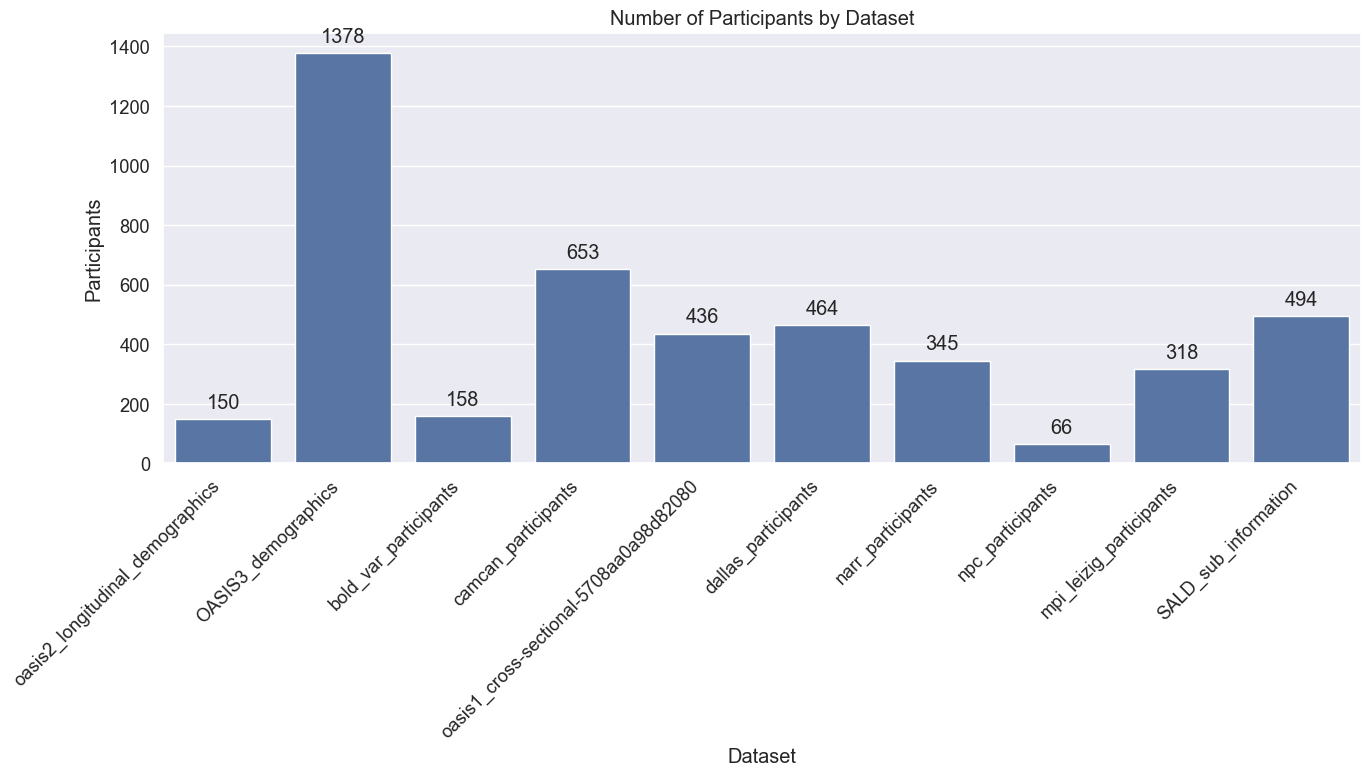

In [140]:
# 1. Number of participants per dataset
plt.figure(figsize=(14, 8))
plot_data = dataset_summary[dataset_summary['Dataset'] != 'TOTAL']
ax = sns.barplot(x='Dataset', y='Participants', data=plot_data)
plt.title('Number of Participants by Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on top of bars
for i, p in enumerate(ax.patches):
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', 
                xytext = (0, 5), textcoords = 'offset points')

plt.savefig('participants_by_dataset.png')
plt.show()

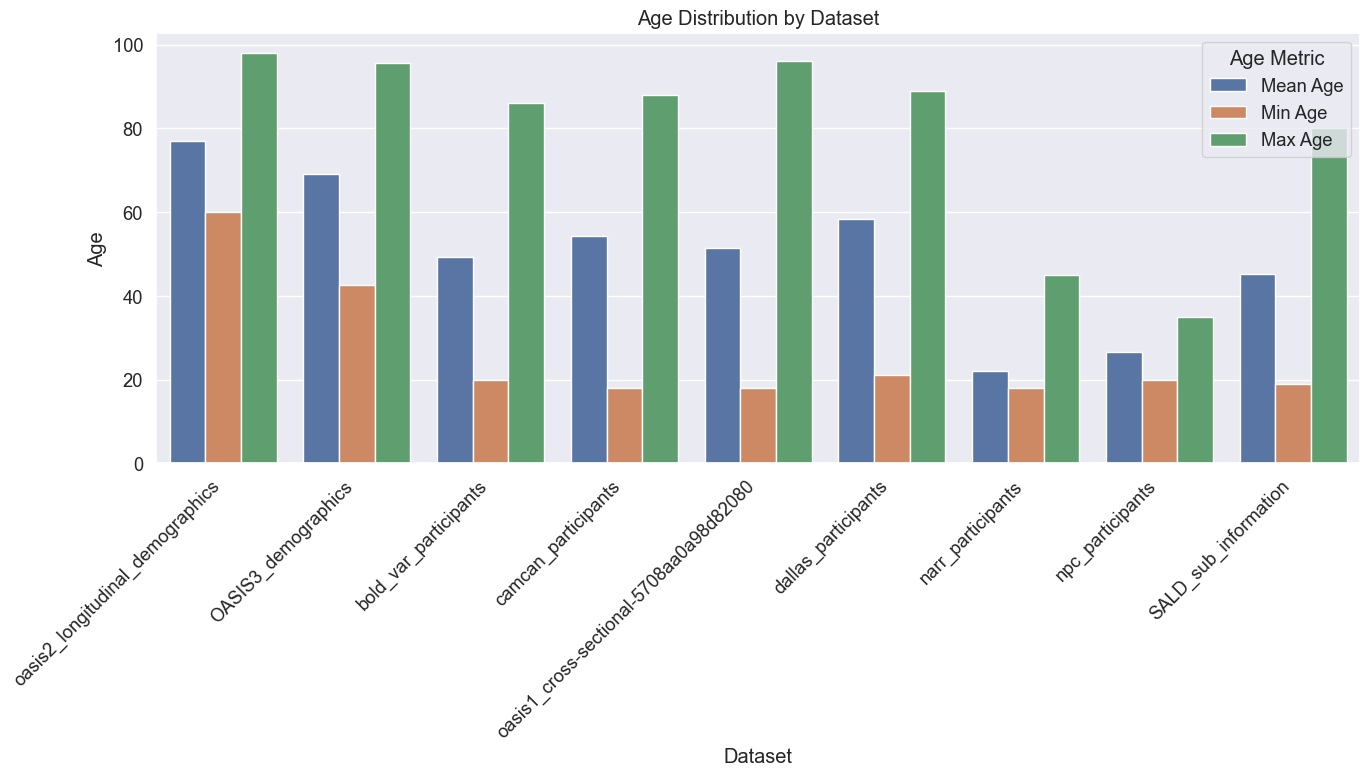

In [141]:
# 2. Age distribution by dataset
plt.figure(figsize=(14, 8))
age_data = plot_data[['Dataset', 'Mean Age', 'Min Age', 'Max Age']].dropna()
age_data = age_data.melt(id_vars=['Dataset'], var_name='Age Metric', value_name='Age')
sns.barplot(x='Dataset', y='Age', hue='Age Metric', data=age_data)
plt.title('Age Distribution by Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('age_by_dataset.png')
plt.show()

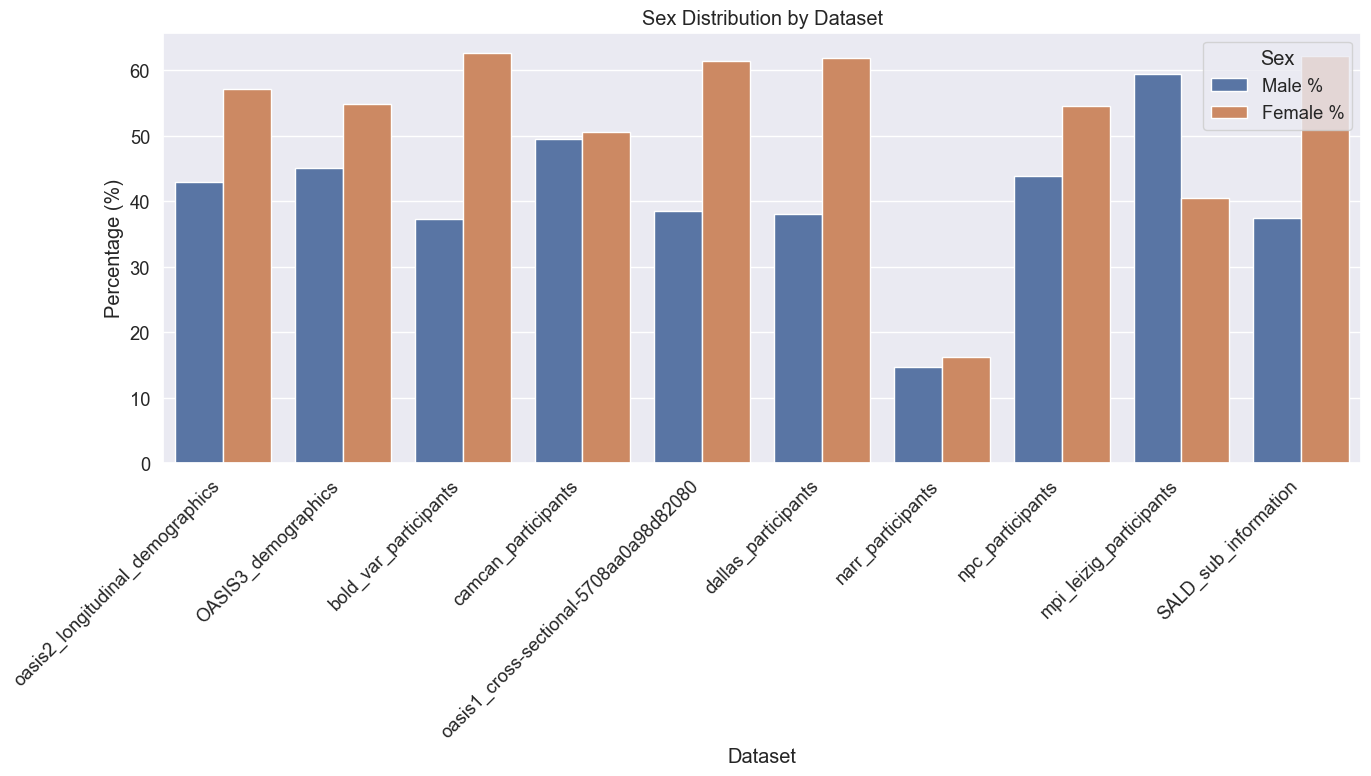

In [142]:
# 3. Sex distribution by dataset
plt.figure(figsize=(14, 8))
sex_data = plot_data[['Dataset', 'Male %', 'Female %']].dropna()
sex_data = sex_data.melt(id_vars=['Dataset'], var_name='Sex', value_name='Percentage')
sns.barplot(x='Dataset', y='Percentage', hue='Sex', data=sex_data)
plt.title('Sex Distribution by Dataset')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage (%)')
plt.tight_layout()
plt.savefig('sex_by_dataset.png')
plt.show()

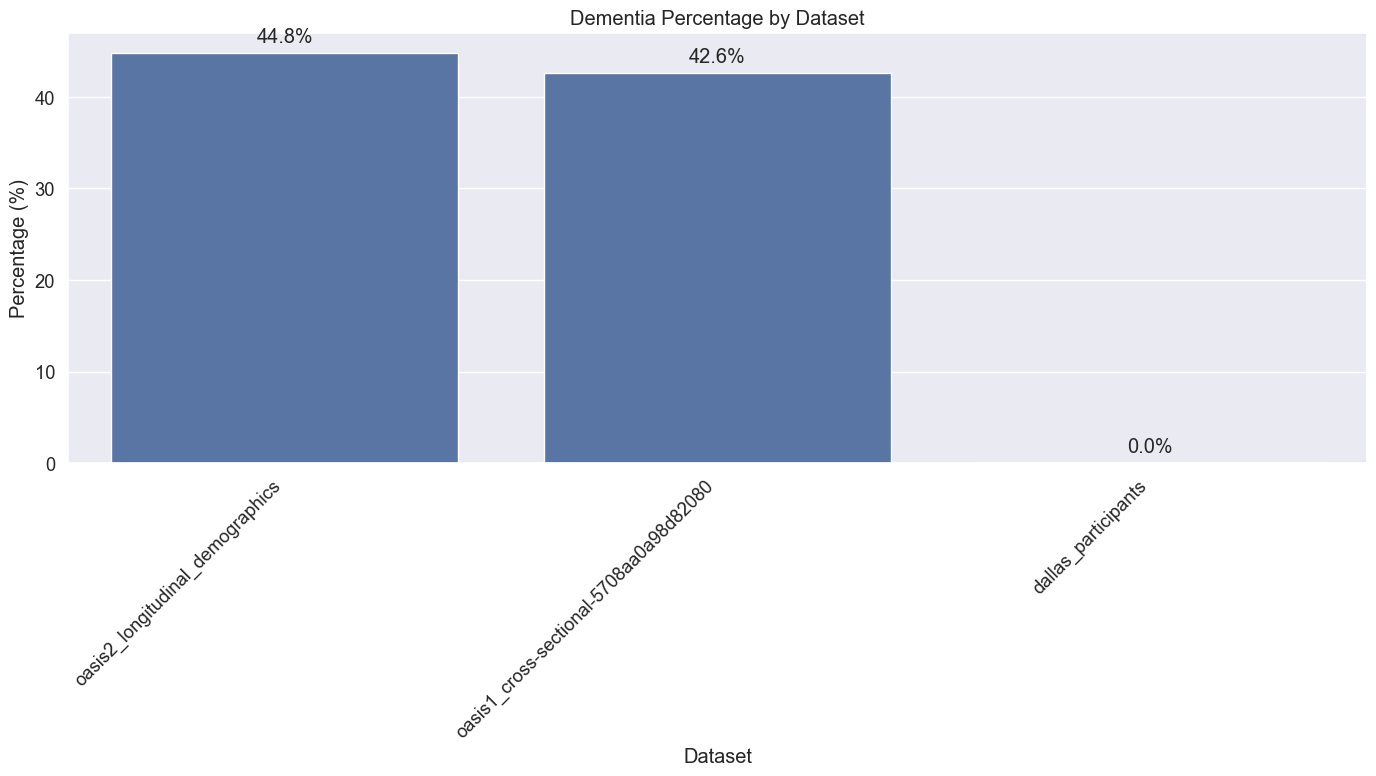

In [143]:
# 4. Dementia percentage by dataset (if available)
dementia_data = plot_data[['Dataset', 'Dementia %']].dropna()
if not dementia_data.empty:
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='Dataset', y='Dementia %', data=dementia_data)
    plt.title('Dementia Percentage by Dataset')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Percentage (%)')
    
    # Add value labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'bottom', 
                    xytext = (0, 5), textcoords = 'offset points')
    
    plt.tight_layout()
    plt.savefig('dementia_by_dataset.png')
    plt.show()

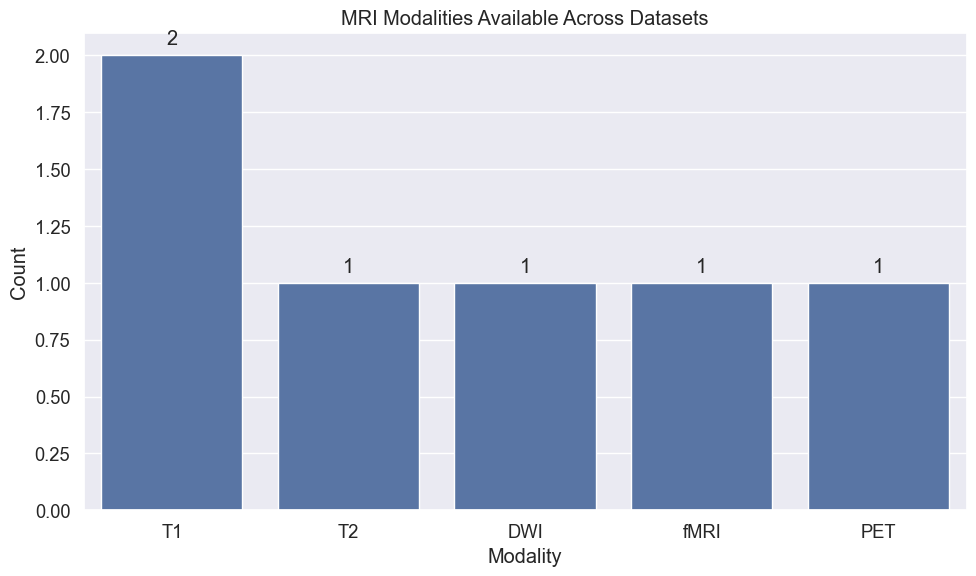

In [144]:
# 5. MRI modalities distribution
modality_data = defaultdict(int)

for idx, row in dataset_summary.iterrows():
    if row['Dataset'] != 'TOTAL' and row['MRI Modalities'] != 'Unknown':
        for modality in row['MRI Modalities'].split(', '):
            modality_data[modality] += 1

if modality_data:
    plt.figure(figsize=(10, 6))
    modality_df = pd.DataFrame({
        'Modality': list(modality_data.keys()),
        'Count': list(modality_data.values())
    })
    ax = sns.barplot(x='Modality', y='Count', data=modality_df)
    
    # Add value labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'bottom', 
                    xytext = (0, 5), textcoords = 'offset points')
    
    plt.title('MRI Modalities Available Across Datasets')
    plt.tight_layout()
    plt.savefig('modality_distribution.png')
    plt.show()

<Figure size 1400x800 with 0 Axes>

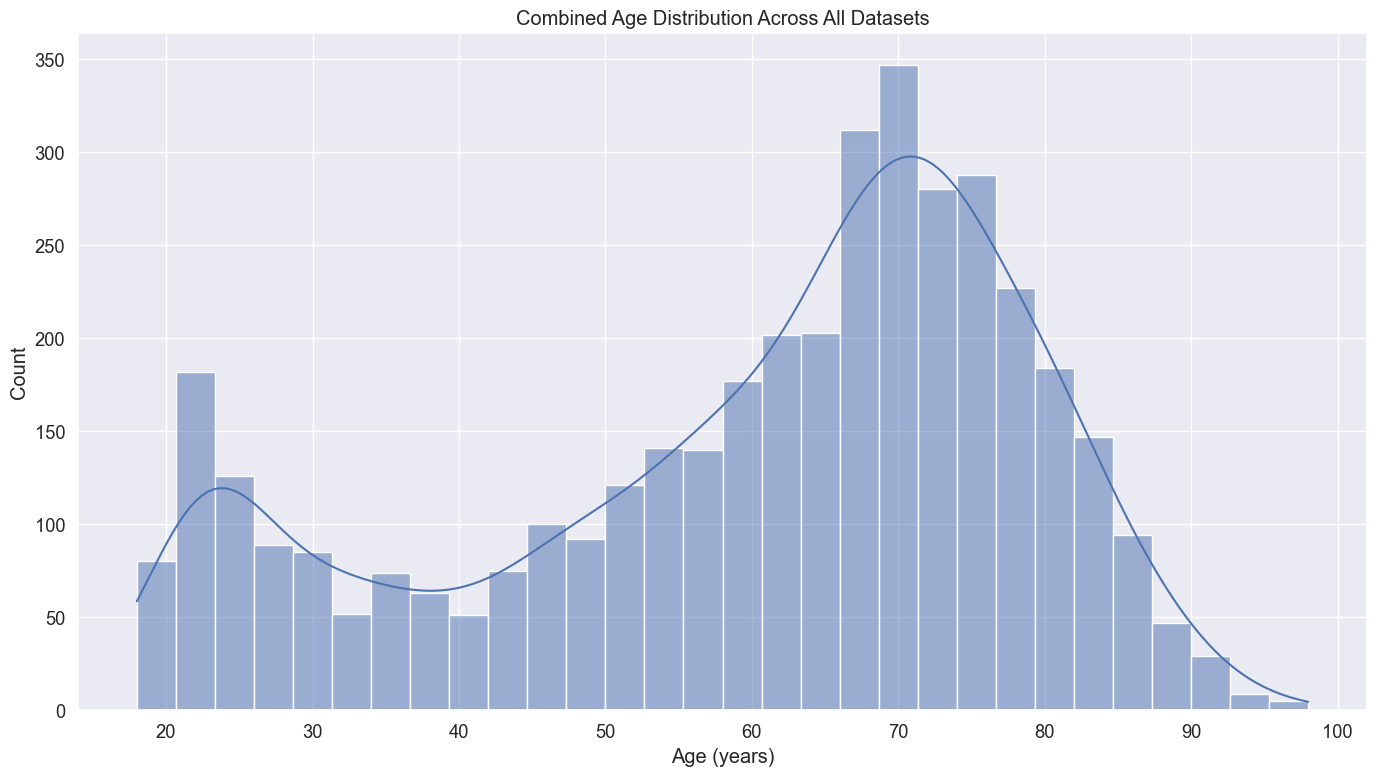

In [145]:
# Age distribution analysis for all datasets combined
plt.figure(figsize=(14, 8))
all_ages = []
dataset_labels = []

for name, df in dfs.items():
    age_cols = [col for col in df.columns if 'age' in col.lower()]
    if age_cols:
        for col in age_cols:
            if pd.api.types.is_numeric_dtype(df[col]):
                valid_ages = df[col].dropna()
                if not valid_ages.empty and valid_ages.max() < 120:  # Filter out unreasonable ages
                    all_ages.extend(valid_ages)
                    dataset_labels.extend([name] * len(valid_ages))
                break

if all_ages:
    age_df = pd.DataFrame({'Age': all_ages, 'Dataset': dataset_labels})
    plt.figure(figsize=(14, 8))
    sns.histplot(data=age_df, x='Age', kde=True, bins=30)
    plt.title('Combined Age Distribution Across All Datasets')
    plt.xlabel('Age (years)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('combined_age_distribution.png')
    plt.show()

## Overall Summary

Key findings from the analysis of all datasets.

In [146]:
# Overall summary
print("\nOverall Summary:")
total_participants = dataset_summary.loc[dataset_summary['Dataset'] == 'TOTAL', 'Participants'].values[0]
print(f"Total participants across all datasets: {int(total_participants)}")

age_range = f"{dataset_summary['Min Age'].min():.1f} - {dataset_summary['Max Age'].max():.1f}"
print(f"Overall age range: {age_range} years")

sex_ratio = f"{dataset_summary.loc[dataset_summary['Dataset'] == 'TOTAL', 'Male %'].values[0]:.1f}% male, " \
           f"{dataset_summary.loc[dataset_summary['Dataset'] == 'TOTAL', 'Female %'].values[0]:.1f}% female"
print(f"Overall sex distribution: {sex_ratio}")

if not dataset_summary['Dementia %'].isna().all():
    dem_percent = dataset_summary.loc[dataset_summary['Dataset'] == 'TOTAL', 'Dementia %'].values[0]
    print(f"Overall dementia percentage: {dem_percent:.1f}%")

# List all available modalities
all_modalities = set()
for idx, row in dataset_summary.iterrows():
    if row['MRI Modalities'] != 'Unknown' and row['Dataset'] != 'TOTAL':
        modalities = row['MRI Modalities'].split(', ')
        all_modalities.update(modalities)

print(f"MRI modalities available across datasets: {', '.join(sorted(all_modalities))}")


Overall Summary:
Total participants across all datasets: 4462
Overall age range: 18.0 - 98.0 years
Overall sex distribution: 40.7% male, 52.2% female
Overall dementia percentage: 29.1%
MRI modalities available across datasets: DWI, PET, T1, T2, fMRI


In [147]:
## Overall Summary
print("\nOverall Summary:")
total_participants = dataset_summary.loc[dataset_summary['Dataset'] == 'TOTAL', 'Participants'].values[0]
print(f"Total participants across all datasets: {int(total_participants)}")

age_range = f"{dataset_summary['Min Age'].min():.1f} - {dataset_summary['Max Age'].max():.1f}"
print(f"Overall age range: {age_range} years")

sex_ratio = f"{dataset_summary.loc[dataset_summary['Dataset'] == 'TOTAL', 'Male %'].values[0]:.1f}% male, " \
            f"{dataset_summary.loc[dataset_summary['Dataset'] == 'TOTAL', 'Female %'].values[0]:.1f}% female"
print(f"Overall sex distribution: {sex_ratio}")

if not dataset_summary['Dementia %'].isna().all():
    dem_percent = dataset_summary.loc[dataset_summary['Dataset'] == 'TOTAL', 'Dementia %'].values[0]
    print(f"Overall dementia percentage: {dem_percent:.1f}%")

# List all available modalities from the summary
all_modalities_used = set()
for idx, row in dataset_summary.iterrows():
    if row['MRI Modalities'] != 'Unknown' and row['Dataset'] != 'TOTAL':
        modalities = row['MRI Modalities'].split(', ')
        all_modalities_used.update(modalities)

print(f"MRI modalities available across datasets: {', '.join(sorted(all_modalities_used))}")


Overall Summary:
Total participants across all datasets: 4462
Overall age range: 18.0 - 98.0 years
Overall sex distribution: 40.7% male, 52.2% female
Overall dementia percentage: 29.1%
MRI modalities available across datasets: DWI, PET, T1, T2, fMRI


# Analysis: Distribution of Modalities, Age and Sex

This notebook cell analyzes how the different MRI modalities are distributed across the datasets and how age and sex vary among them. For each dataset (except the overall combined row), a summary has been computed (stored in `dataset_summary`).

The analysis for each modality includes:

- **Participant Count:** Total number of participants (thus, MRI images) for that modality
- **Weighted Mean Age:** A mean computed by weighting the dataset mean age by its participant count
- **Sex Distribution:** Overall percentages of male, female, and unknown sex participants

The results are then visualized using bar plots.

Modality Summary:
  Modality  Total Participants  Weighted Mean Age     Male %   Female %  \
0       T1                 652          46.176380  37.423313  62.269939   
1       T2                 158          49.278481  37.341772  62.658228   
2      DWI                 158          49.278481  37.341772  62.658228   
3     fMRI                 158          49.278481  37.341772  62.658228   
4      PET                 464          58.312500  38.146552  61.853448   

   Unknown Sex %  
0       0.306748  
1       0.000000  
2       0.000000  
3       0.000000  
4       0.000000  


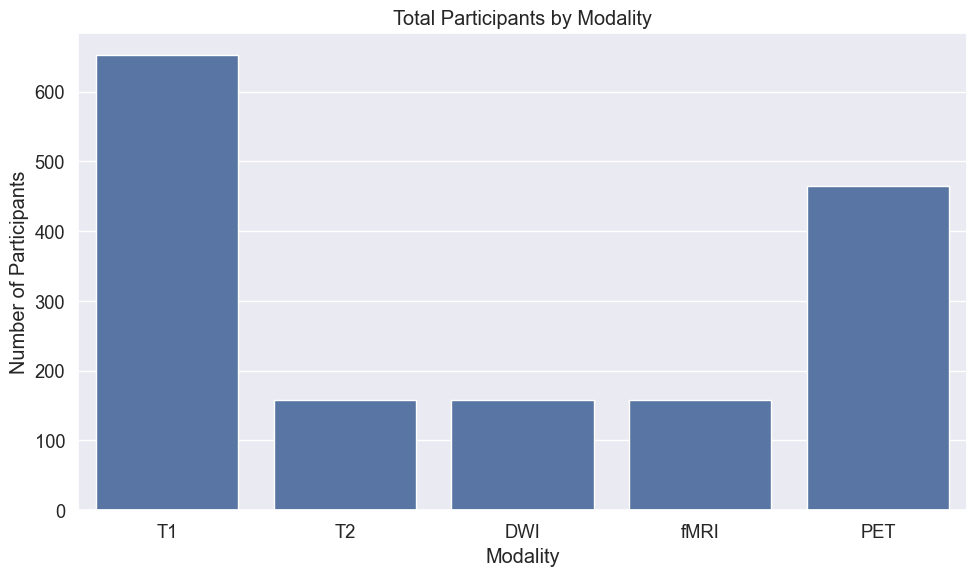

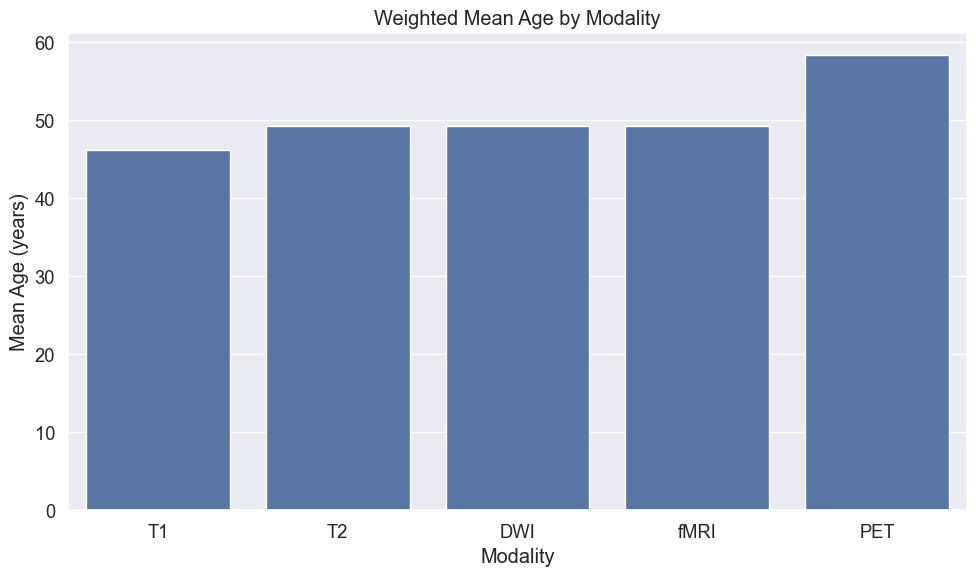

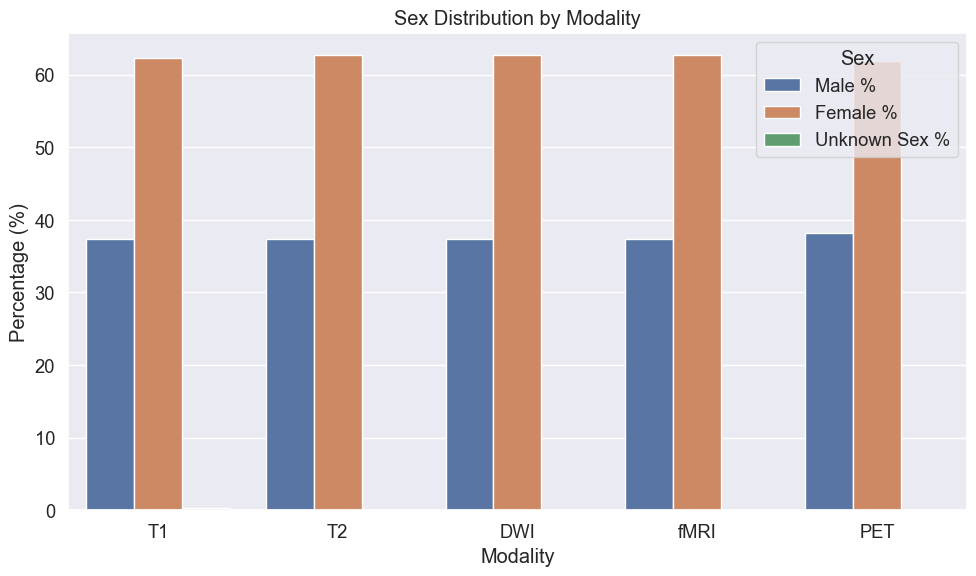

In [148]:
# --- Begin Modality, Age and Sex Distribution Analysis ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that the plotting style is set
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

# --- Aggregation by Modality ---
# We loop over each dataset row (ignoring the overall 'TOTAL' row) in dataset_summary,
# and for each modality listed in the row (if available), we accumulate:
#   - total number of participants
#   - weighted sum of the mean age (to later compute a weighted mean age)
#   - raw counts for male, female, and unknown (computed from percentages * participant count)

modality_stats = {}

for idx, row in dataset_summary.iterrows():
    # Skip the overall total row
    if row['Dataset'] == 'TOTAL':
        continue
    
    modalities = row['MRI Modalities']
    if pd.isna(modalities) or modalities == 'Unknown' or modalities.strip() == '':
        continue
    
    # Split modalities by comma (each dataset might list more than one modality)
    mods = [m.strip() for m in modalities.split(',')]
    
    for mod in mods:
        if mod not in modality_stats:
            modality_stats[mod] = {
                'total_participants': 0,
                'weighted_age_sum': 0,
                'male_count': 0,
                'female_count': 0,
                'unknown_count': 0
            }
        
        participants = row['Participants']
        modality_stats[mod]['total_participants'] += participants
        
        # Use the mean age if available (skip dataset if NaN, assuming 0 contribution otherwise)
        mean_age = row['Mean Age'] if not pd.isna(row['Mean Age']) else 0
        modality_stats[mod]['weighted_age_sum'] += mean_age * participants
        
        # Compute raw counts for each sex group from percentages
        male_pct = row['Male %'] if not pd.isna(row['Male %']) else 0
        female_pct = row['Female %'] if not pd.isna(row['Female %']) else 0
        unknown_pct = row['Unknown Sex %'] if not pd.isna(row['Unknown Sex %']) else 0
        
        modality_stats[mod]['male_count'] += (male_pct/100) * participants
        modality_stats[mod]['female_count'] += (female_pct/100) * participants
        modality_stats[mod]['unknown_count'] += (unknown_pct/100) * participants

# Create a summary DataFrame from the aggregated modality stats
modality_data = []
for mod, stats in modality_stats.items():
    total = stats['total_participants']
    if total > 0:
        weighted_mean_age = stats['weighted_age_sum'] / total
        male_pct = 100 * (stats['male_count'] / total)
        female_pct = 100 * (stats['female_count'] / total)
        unknown_pct = 100 * (stats['unknown_count'] / total)
    else:
        weighted_mean_age = np.nan
        male_pct = female_pct = unknown_pct = np.nan
    modality_data.append({
        'Modality': mod,
        'Total Participants': total,
        'Weighted Mean Age': weighted_mean_age,
        'Male %': male_pct,
        'Female %': female_pct,
        'Unknown Sex %': unknown_pct
    })

modality_summary_df = pd.DataFrame(modality_data)
print("Modality Summary:")
print(modality_summary_df)

# --- Visualizations ---

# 1. Bar Plot: Total Participants by Modality
plt.figure(figsize=(10,6))
sns.barplot(data=modality_summary_df, x='Modality', y='Total Participants')
plt.title('Total Participants by Modality')
plt.xlabel('Modality')
plt.ylabel('Number of Participants')
plt.tight_layout()
plt.show()

# 2. Bar Plot: Weighted Mean Age by Modality
plt.figure(figsize=(10,6))
sns.barplot(data=modality_summary_df, x='Modality', y='Weighted Mean Age')
plt.title('Weighted Mean Age by Modality')
plt.xlabel('Modality')
plt.ylabel('Mean Age (years)')
plt.tight_layout()
plt.show()

# 3. Grouped Bar Plot: Sex Distribution by Modality
sex_df = modality_summary_df.melt(
    id_vars='Modality',
    value_vars=['Male %', 'Female %', 'Unknown Sex %'],
    var_name='Sex',
    value_name='Percentage'
)

plt.figure(figsize=(10,6))
sns.barplot(data=sex_df, x='Modality', y='Percentage', hue='Sex')
plt.title('Sex Distribution by Modality')
plt.xlabel('Modality')
plt.ylabel('Percentage (%)')
plt.tight_layout()
plt.show()

# --- End of Analysis ---

Total consolidated participant rows (duplicates if multi-modal): 9265
Age bins used: [18. 20. 22. 24. 26. 28. 30. 32. 34. 36. 38. 40. 42. 44. 46. 48. 50. 52.
 54. 56. 58. 60. 62. 64. 66. 68. 70. 72. 74. 76. 78. 80. 82. 84. 86. 88.
 90. 92. 94. 96.]

Grouped counts (first 5 rows):
  Modality     Sex        AgeBin  Count
0       CT  Female  [18.0, 20.0)      0
1       CT  Female  [20.0, 22.0)      0
2       CT  Female  [22.0, 24.0)      0
3       CT  Female  [24.0, 26.0)      0
4       CT  Female  [26.0, 28.0)      0

Missing combinations (should be empty if data is balanced):
    Modality      Sex        AgeBin  Count
0         CT     Male  [18.0, 20.0)      0
1         CT     Male  [20.0, 22.0)      0
2         CT     Male  [22.0, 24.0)      0
3         CT     Male  [24.0, 26.0)      0
4         CT     Male  [26.0, 28.0)      0
..       ...      ...           ...    ...
463       T2  Unknown  [86.0, 88.0)      0
464       T2  Unknown  [88.0, 90.0)      0
465       T2  Unknown  [90.0, 9

C:\Users\P095382\AppData\Local\Temp\ipykernel_29576\1833122791.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = all_participants.groupby(['Modality', 'Sex', 'AgeBin']).size().reset_index(name='Count')


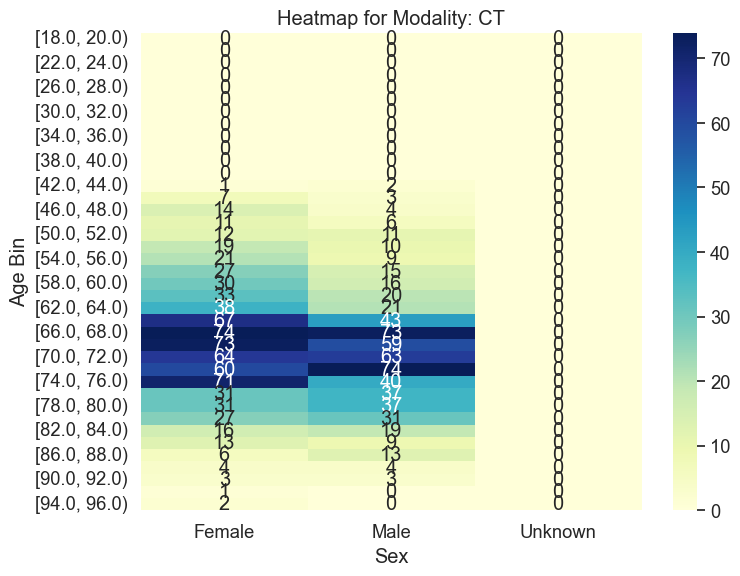

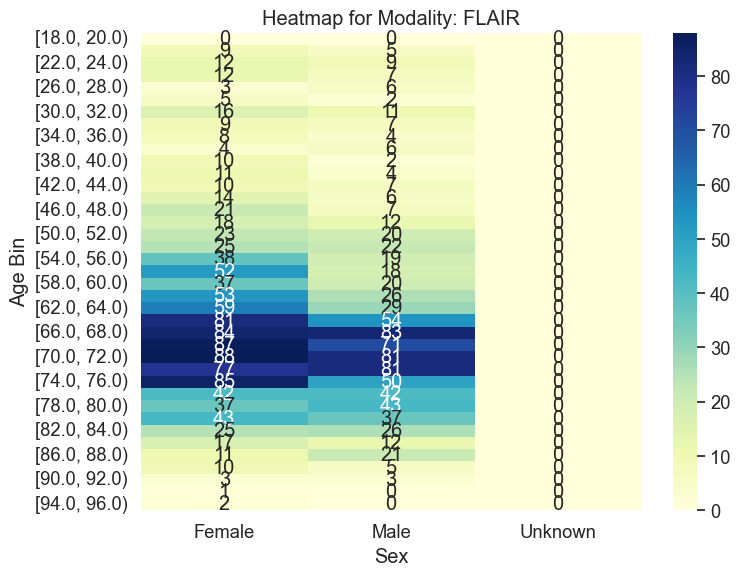

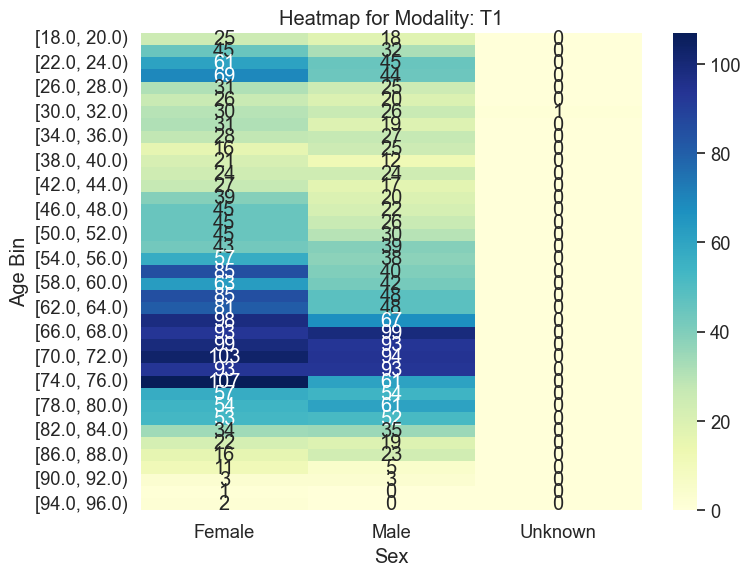

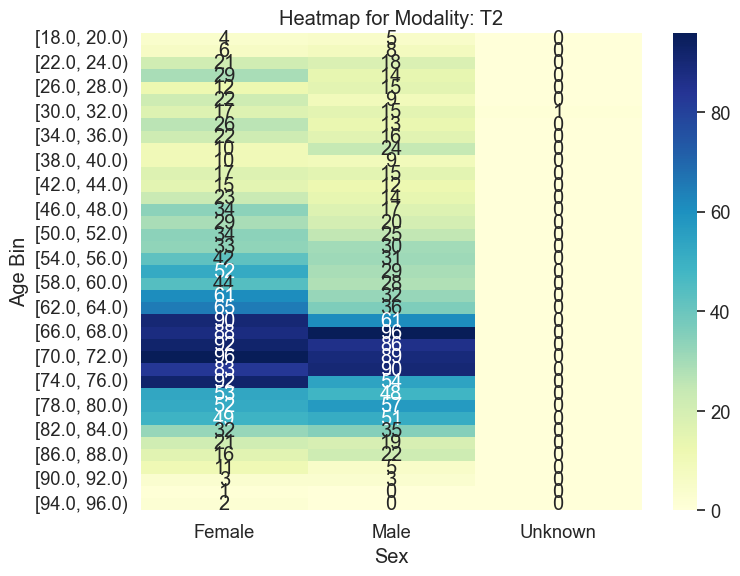

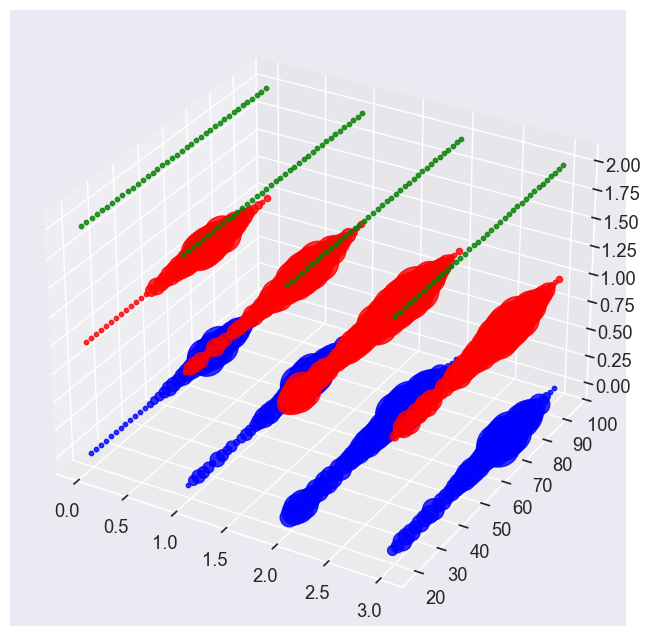

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


age_bin_size = 2
# Helper function: Clean modality string
def clean_modality(mod):
    mod_clean = mod.replace('?', '').strip().upper()
    if '+' in mod_clean:
        parts = mod_clean.split('+')
        return [p.strip() for p in parts]
    return [mod_clean]

# ---- Consolidate participant-level data from all datasets ----
# For each dataset in dfs that is included in dataset_modalities, extract age and sex.
# When there are multiple modalities, duplicate the row for each modality.
rows = []

for dataset_key, df in dfs.items():
    if df is None:
        continue
    if dataset_key not in dataset_modalities:
        continue
    modalities = dataset_modalities[dataset_key]
    if not modalities:
        continue

    # Identify candidate columns for age and sex (simple heuristic)
    age_candidates = [col for col in df.columns if 'age' in col.lower()]
    sex_candidates = [col for col in df.columns if ('sex' in col.lower()) or ('gender' in col.lower())]
    if not age_candidates or not sex_candidates:
        continue
    age_col = age_candidates[0]
    sex_col = sex_candidates[0]

    for i, row_data in df.iterrows():
        try:
            age_val = float(row_data[age_col])
        except:
            continue

        sex_val = str(row_data[sex_col]).strip().lower()
        if sex_val in ['m', 'male', '1', 'man', 'boy']:
            sex_std = 'Male'
        elif sex_val in ['f', 'female', '2', 'woman', 'girl']:
            sex_std = 'Female'
        else:
            sex_std = 'Unknown'

        for modality in modalities:
            for mod in clean_modality(modality):
                rows.append({
                    'Dataset': dataset_key,
                    'Age': age_val,
                    'Sex': sex_std,
                    'Modality': mod
                })

all_participants = pd.DataFrame(rows)
print("Total consolidated participant rows (duplicates if multi-modal):", all_participants.shape[0])
if all_participants.empty:
    print("Warning: No participant-level data was extracted. Check your dataset files and column names.")

# ---- Bin Age into 5-Year Intervals ----
if not all_participants.empty:
    min_age = all_participants['Age'].min()
    max_age = all_participants['Age'].max()
    bins = np.arange(np.floor(min_age/age_bin_size)*age_bin_size, np.ceil(max_age/age_bin_size)*age_bin_size+ age_bin_size, age_bin_size)
    all_participants['AgeBin'] = pd.cut(all_participants['Age'], bins=bins, right=False, include_lowest=True)
    print("Age bins used:", bins)

# ---- Group by Modality, Sex, and Age Bin ----
grouped = all_participants.groupby(['Modality', 'Sex', 'AgeBin']).size().reset_index(name='Count')
print("\nGrouped counts (first 5 rows):")
print(grouped.head())

# ---- Check for Missing Combinations ----
modalities_list = sorted(all_participants['Modality'].unique())
sex_categories = ['Male', 'Female', 'Unknown']
age_bins_categories = all_participants['AgeBin'].cat.categories if not all_participants.empty else []
full_index = pd.MultiIndex.from_product([modalities_list, sex_categories, age_bins_categories],
                                          names=['Modality', 'Sex', 'AgeBin'])
grouped_full = grouped.set_index(['Modality', 'Sex', 'AgeBin']).reindex(full_index, fill_value=0).reset_index()
missing = grouped_full[grouped_full['Count'] == 0]
print("\nMissing combinations (should be empty if data is balanced):")
print(missing)

# ---- Visualize with Heatmaps (One per Modality) ----
for mod in modalities_list:
    subset = grouped_full[grouped_full['Modality'] == mod]
    if subset.empty:
        continue
    pivot_table = subset.pivot(index='AgeBin', columns='Sex', values='Count')
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(f"Heatmap for Modality: {mod}")
    plt.ylabel("Age Bin")
    plt.xlabel("Sex")
    plt.tight_layout()
    plt.show()

# ---- 3D Scatter Plot: Data Cloud of All Combinations ----
# Map modality to an x-index and sex to a z-index.
modality_to_idx = {mod: idx for idx, mod in enumerate(modalities_list)}
sex_to_idx = {'Male': 0, 'Female': 1, 'Unknown': 2}

# Function to compute the center of an age bin for plotting.
def bin_center(agebin):
    return agebin.left + (agebin.right - agebin.left)/2

grouped_full['AgeBinCenter'] = grouped_full['AgeBin'].apply(bin_center)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Plot each combination (bubble size proportional to count).
for i, row in grouped_full.iterrows():
    x_val = modality_to_idx.get(row['Modality'], 0)
    y_val = row['AgeBinCenter']
    z_val = sex_to_idx.get(row['Sex'], 0)
    count = row['Count']
    color = {'Male': 'blue', 'Female': 'red', 'Unknown': 'green'}.get(row['Sex'], 'gray')
    ax.scatter(x_val, y_val, z_val, s=count*10 if count > 0 else 10, c=color, alpha=0.8)
